# 합성곱 신경망(CNN)

딥러닝을 활용한 기법들은 거의 다 CNN을 기초를 두고있다.

지금까지 살펴본 구조는 인접하는 계층의 모든 뉴런과 결합되어 있는 **fully-connected(완전연결)** 구조로 `Affine-ReLU`구조가 쌓이다가 마지막 층에 `Affine-Softmax`구조로 이루어졌다.

하지만 CNN은 `합성곱 계층(Conv)-ReLU-풀링 계층(Pooling)` 으로 이루어진다. 완전 연결 구조와는 다르게 Pooling 계층이 빠진 `Conv-ReLU`구조도 사용할 수 있다. 그리고 출력에 가까운 층에서는 `Affine-ReLU`구조를 사용할 수 있고, 출력 계층에서는 `Affine-Softmax`를 사용한다.

## 1. 합성곱 계층

### 1.1. 완전연결 계층의 문제점

완전연결 계층은 다음과 같은 특징을 갖는다.
1. 인접하는 계층의 뉴련이 모두 연결
2. 출력의 수를 임의로 설정 가능
3. 데이터의 형상 무시

이 중에서 데이터 형상을 무시하는 것이 문제가 된다. 입력으로 n 차원이 입력되더라도 1 차원으로 변형을 거쳐야한다. 이로 인해 입력 데이터의 형상에 담긴 정보를 살릴 수 없게 된다.

합성곱 입출력 데이터를 **특징 맵**이라고 하며 형상을 유지한다.
- **입력 특징 맵** : 입력 데이터
- **출력 특징 맵** : 출력 데이터

### 1.2. 합성곱 연산

합성곱 연산은 **필터**를 사용한다. 입력 데이터에서 필터와 대응하는 원소끼리 곱한 후 그 총합을 구한다. 이러한 계산을 **Fused Multiply-Add(단일 곱셈-누산)** 이라고 한다.

신경망에서는 가중치 매개변수와 편항을 사용했다. CNN에서는 필터의 매개변수가 **가중치**에 해당한다. 

#### 1.2.1. 패딩

**패딩** 합성곱 연산을 수행하기 전에 입력 데이터 주변을 특정 값으로 채운다. 이를 통해 출력 데이터의 크기를 크게 만들 수 있다.

#### 1.2.2. 스트라이드

필터를 적용하는 위치 간격을 **스트라이드**라고 한다. 아룰 통해 출력 데이터의 크기를 작게 만들 수 있다.

#### 1.2.3. 원도우

입력 데이터에서 필터가 적용되는 부분을 **윈도우**라고 한다.

#### 1.2.4. 출력 차원

필터의 개수에 따라 출력 데이터의 **차원(채널)**을 결정한다. 이를 통해 각 계층을 흐르는 데이터의 차원을 동일하게 유지할 수 있다.

## 2. 풀링 계층

**풀링**은 공간을 줄이는 연산으로 다음과 같은 특징을 갖는다.

1. 학습해야 할 매개변수가 없다.
2. 채널 수가 변하지 않는다.
3. 입력의 변화에 영향을 적게 받는다.

### 2.1. 최대 풀링

풀링 영역 내부 원소 중 가장 큰 원소를 꺼낸다. 이미지 인식에서 주로 사용한다. 

### 2.2. 평균 풀링

풀링 영역 내부 원소의 평균을 계산한다.

## 3. 합성곱/풀링 계층 구현

CNN에서는 배열의 **높이, 너비, 채널 수**의 3차원 데이터를 사용한다. 여기서 배치 처리를 위해 차원을 1개 늘려 총 **4 차원**의 데이터를 사용한다. 

`입력데이터(N, C, H, W) * 필터(FN, C, FH, FW) + 편향(FN, 1, 1) = 출력데이터(N, FN, OH, OW`

### 3.1. 차원 배열

높이 28, 너비 28, 채널 1개인 데이터가 10개인 데이터 형상은 다음과 같이 표현한다.

In [3]:
import numpy as np

x = np.random.rand(10, 1, 28, 28)

In [6]:
print("전체 데이터 형상 :", x.shape)
print("첫 번째 데이터 형상 :", x[0].shape)
print("첫 번째 채널 형상 :", x[0, 0].shape)

전체 데이터 형상 : (10, 1, 28, 28)
첫 번째 데이터 형상 : (1, 28, 28)
첫 번째 채널 형상 : (28, 28)


위와 같이 다차원 배열을 합성곱 연산에 사용하기 위해서는 for문을 반복해야 한다. 하지만 numpy에 for문을 사용하면 성능이 떨어진다. 따라서 for문 대신 **im2col**을 사용한다.

in2col은 입력 데이터를 필터링하기 좋게 전개하는 함수다. CNN에서는 4차원 데이터를 2차원으로 변환한다. 

- 장점 : 큰 행렬을 묶어 계산하는데 편리
- 단점 : 메모리를 많이 소비

**im2col(input_data, filter_h, filter_w, stride=1, pad=0)**

- **input_data** : (데이터수, 채널수, 높이, 너비)의 4차원 배열로 이루어진 데이터
- **filter_h** : 필터 높이
- **filter_w** : 필터 너비
- **stride** : 스트라이드
- **pad** : 패딩

In [ ]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    # 다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).

    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

### 3.2. 합성곱 계층 구현

im2col을 사용하여 합성곱 계층을 구현하면 다음과 같다.

In [1]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T # 필터 전개

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        return out

**reshape에 -1을 지정**하면 다차원 배열의 원소 수가 변환 후에도 똑같이 유지되도록 묶어준다. 위 코드에서 배열 W의 원소의 총 수는 750개다. 이 배열에 reshape(10, -1)을 하면 750개의 원소를 10 묶음으로 만든다. 즉 (10, 75)가 된다.

**transpose()** 는 다차원 배열의 축 순서를 바꿔주는 함수다. 원래 배열의 인덱스 번호로 축의 순서를 변경한다. 위 코드에서 원래 배열이 (N, H, W, C)에서 (N, C, H, W)로 바뀌었다.

### 3.3. 폴링 계층 구현

풀링은 다음과 같은 단계로 진행된다.
1. 입력 데이터 전개
2. 행별 최댓값 수색
3. 적절한 모양으로 성형

이를 코드로 구현하면 다음과 같다.

In [2]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # 1. 전개
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        # 2. 최댓값
        out = np.max(col, axis=1)
        
        # 3. 성형
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        return out

## 4. CNN 구현

`Conv-ReLU-Pooling-Affine-ReLU-Affine-Softmax`구조의 CNN 네트워크를 구현하면 다음과 같다. 

In [1]:
import sys, os
sys.path.append(os.pardir) 
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:

    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        
        # 합성곱 계층의 하이퍼파라미터를 딕셔너리에 저장
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        # 합성곱 계층의 출력 크기 계산
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        """추론 수행"""
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
        grads['W1']、grads['W2']、... 각 층의 가중치
        grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
        grads['W1']、grads['W2']、... 각 층의 가중치
        grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

초기화 때 받는 인수들은 다음과 같다.

1. **input_dim** : 입력 데이터(채널 수, 높이, 너비)의 차원
2. **conv_param** : 합성곱 계층의 파라미터
3. **filter_num** : 필터 수
4. **fiter_size** : 필터 크기
5. **stride** : 스트라이드
6. **pad** : 패딩
7. **hidden_size** : 은닉층의 뉴런 수
8. **output_size** : 출력층의 뉴런 수
9. **weight_init_std** : 초기화 때의 가중치 표준편차

위 코드로 MNIST 데이터셋을 학습하는 코드는 다음과 같다.

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:39<00:00,  2.50it/s]


test acc:0.957
Saved Network Parameters!


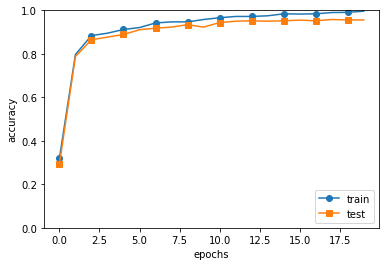

In [2]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer


from common.optimizer import *

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()
    
# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()